## Explaining Deep Cluster Assignments with Neuralized K-Means on Image Data

In [1]:
dummy = False
# for colab folks
# %pip install zennit
# dummy = False

In [2]:
# Basic boilerplate code
from torchvision import datasets, transforms
from torchvision.models import vgg16
import torch
import numpy as np

transform_img = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224)])
transform_norm = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

transform = transforms.Compose([
    transform_img,
    transforms.ToTensor(),
    transform_norm
])

### Data and weights

In [6]:
## Data loading
if dummy:
    images, labels = transform_norm(torch.randn(3, 3, 224, 224).clamp(min=0, max=1)), torch.tensor([0,1,2])
    features = vgg16(weights=None).eval()._modules['features']
else:
    from torch.utils.data import SubsetRandomSampler, DataLoader

    # Attention: the next row downloads a dataset into the current folder!
    dataset = datasets.Caltech101(root='.', transform=transform, download=True)

    categories = ['cougar_body', 'Leopards', 'wild_cat']

    all_indices = []
    for category in categories:
        category_idx = dataset.categories.index(category)
        category_indices = [i for i, label in enumerate(dataset.y) if label == category_idx]

        num_samples = min(7, len(category_indices))

        selected_indices = np.random.choice(category_indices, num_samples, replace=False)
        all_indices.extend(selected_indices)

    sampler = SubsetRandomSampler(all_indices)
    loader = DataLoader(dataset, batch_size=21, sampler=sampler)

    try:
        images, labels = next(iter(loader))
    except Exception as e:
        print(f"Exception: {e}\nSimply run the cell again.")

    ## Feature extractor
    features = vgg16(weights='IMAGENET1K_V1').eval()._modules['features']

### The fun begins here

We construct a feature map $\phi$ from image space to feature space.
Here, we sum over spatial locations in feature space to get more or less translation invariance in pixel space.

In [7]:
from zennit.layer import Sum

phi = torch.nn.Sequential(
    features,
    Sum((2,3))
)

Z = phi(images).detach()

Use simple `scikit-learn.KMeans` on the features:

In [8]:
# initialize on class means
# because we have very few data points here
centroids = np.stack([Z[labels == y].mean(0) for y in labels.unique()])

In [9]:
if not dummy:
    from sklearn.cluster import KMeans
    standard_kmeans = KMeans(n_clusters=3, n_init='auto', init=centroids).fit(Z)
    centroids = standard_kmeans.cluster_centers_

Now build a deep clustering model that takes images as input and predicts the k-means assignments

We also apply a little scaling trick that makes heatmaps nicer, but usually does not change the cluster assignments.

In [10]:
from zennit.layer import PairwiseCentroidDistance

# it's not necessary, just looks a bit nicer
s = ((centroids**2).sum(-1, keepdims=True)**.5)
s = s / s.mean()

model = torch.nn.Sequential(
    phi,
    PairwiseCentroidDistance(torch.from_numpy(centroids / s).float())
)

### Enter zennit.

In [11]:
# import zennit
from zennit.attribution import Gradient
from zennit.composites import EpsilonGammaBox
from zennit.image import imgify
from zennit.torchvision import VGGCanonizer
from zennit.canonizers import KMeansCanonizer
from zennit.composites import LayerMapComposite, MixedComposite
from zennit.layer import NeuralizedKMeans, MinPool1d
from zennit.rules import ZPlus, Gamma, TakesMost

def data2img(x):
    return (x.squeeze().permute(1,2,0) * torch.tensor([0.229, 0.224, 0.225])) + torch.tensor([0.485, 0.456, 0.406])

In [12]:
# compute cluster assignments and check if they are equal
# without the scaling trick above, the are definitely equal (trust me)
ypred = model(images).argmin(1)
# assert (ypred.numpy() == standard_kmeans.predict(Z)).all()

### Everything is ready.

You can play around with the `beta` parameter in `MinTakesMost1d` and the `gamma` parameter in `Gamma`.

`beta` is a contrast parameter. Keep `beta < 0`.
Small negative `beta` can be seen as *one-vs-all* explanation whereas large negative `beta` is more like *one-vs-nearest-competitor*.

The `gamma` parameter controls the contribution of negative weights. Keep `gamma >= 0`.
In practice, small (positive) `gamma` can result in entirely negative heatmaps. Think of thousand negative weights and a single positive weight. The positive weight could be enough to win the k-means assignment in feature space, but it's lost after a few layers because the graph is flooded with negative contributions.

If you are trying to explain contribution to another cluster (say, $x$ is assigned to cluster $1$, but you want to see if there is some evidence for cluster $2$ in the image), then definitely cramp up `gamma` or even use `ZPlus` instead of `Gamma`.

Cluster 0


Cluster 1


Cluster 2


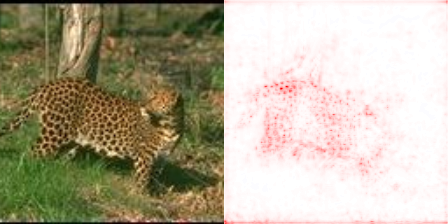

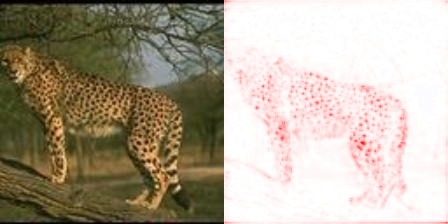

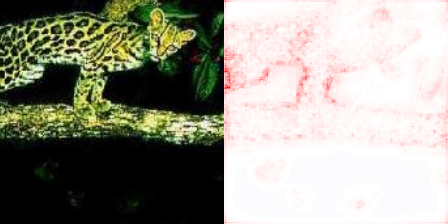

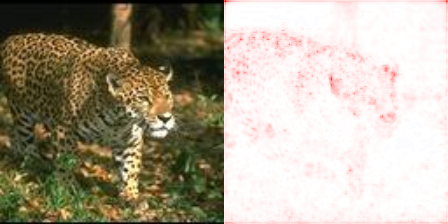

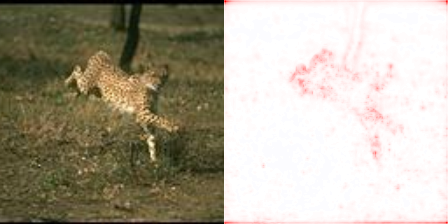

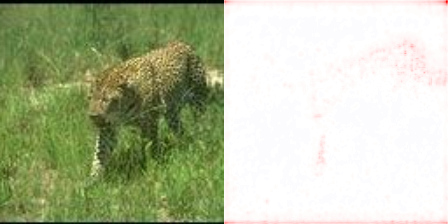

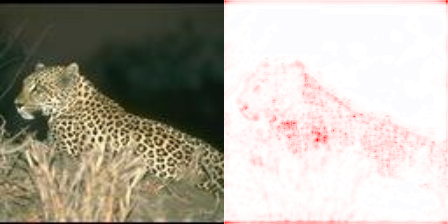

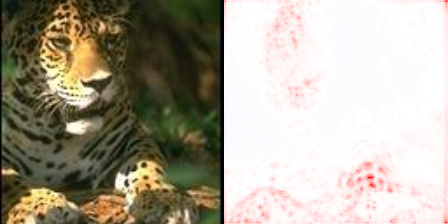

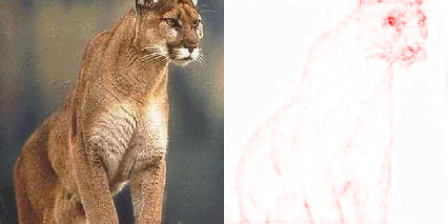

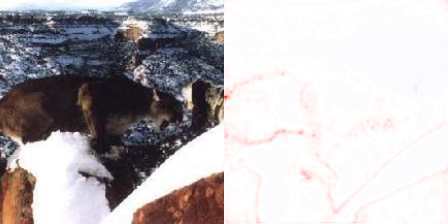

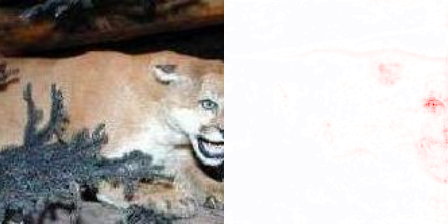

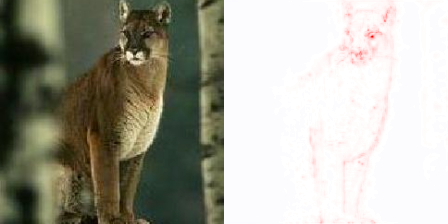

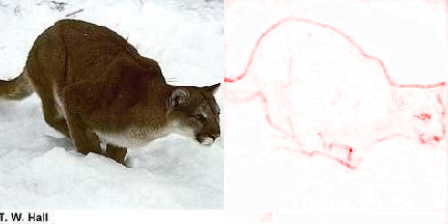

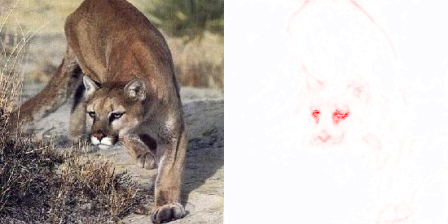

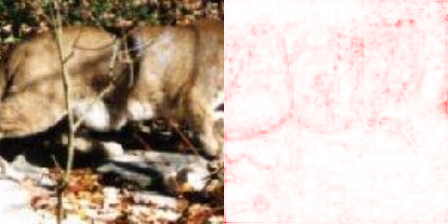

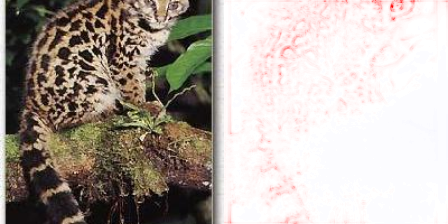

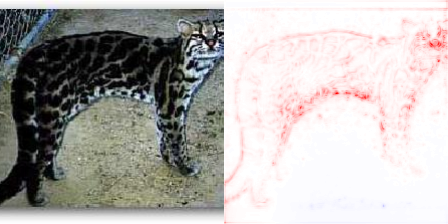

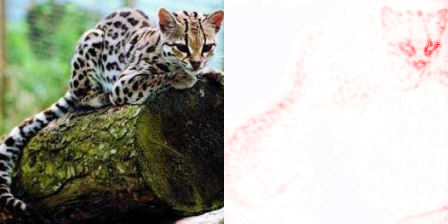

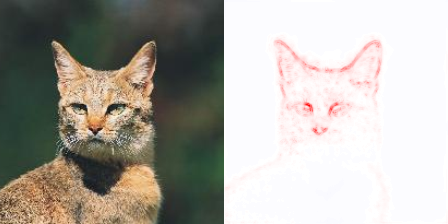

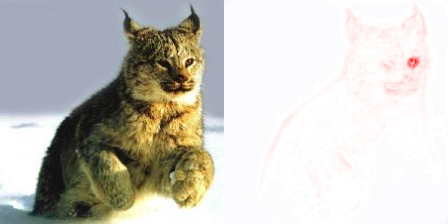

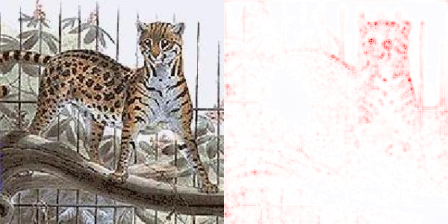

In [13]:
canonizer = KMeansCanonizer()

low, high = transform_norm(torch.tensor([[[[[0.]]] * 3], [[[[1.]]] * 3]]))

composite = MixedComposite([
    EpsilonGammaBox(low=low, high=high, canonizers=[canonizer]),
    LayerMapComposite([
        (NeuralizedKMeans,   Gamma(gamma=.25)),
        (MinPool1d,          TakesMost(beta=-1., dimensions=1)),
        (torch.nn.MaxPool2d, TakesMost(beta=.1, dimensions=2))
    ])
])

with Gradient(model=model, composite=composite) as attributor:
    for c in range(len(centroids)):
        print("Cluster %d"%c)
        cluster_members = (ypred == c).nonzero()[:,0]
        for i in cluster_members:
            img = images[i].unsqueeze(0)
            target = torch.eye(len(centroids))[[c]]
            output, attribution = attributor(img, target)
            relevance = attribution[0].sum(0)

            heatmap = np.array(imgify(relevance, symmetric=True, cmap='seismic').convert('RGB'))
            display(imgify(np.stack([data2img(img).numpy(), heatmap]), grid=(1,2)))